### Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from matplotlib import cm
from statsmodels.api import OLS
from pandas.tools.plotting import scatter_matrix
from pandas import scatter_matrix
import scipy as sci

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### Load, Visualize, and Clean Data

In [2]:
target_col = "sub_grade"
full_loan_stats = pd.read_csv('CS_109A/git_repo/s109/Lending Club Project/LoanStats3d.csv', skiprows=1, skipfooter=2, engine='python')
loan_df = full_loan_stats.copy()

In [3]:
loan_df.groupby(['loan_status']).agg({'loan_status': np.size})

,loan_status
loan_status,
Charged Off,68293
Current,115887
Default,8
Fully Paid,229963
In Grace Period,2668
Late (16-30 days),809
Late (31-120 days),3467


We see that there are categories of the loan_status have very few observations. Since we are really interested in the loan getting to good term, instead of trying to predict the status, we turn it in a binary category, indicating if it is current (non risky) or falls into any of the other categories, which we'll call risky.

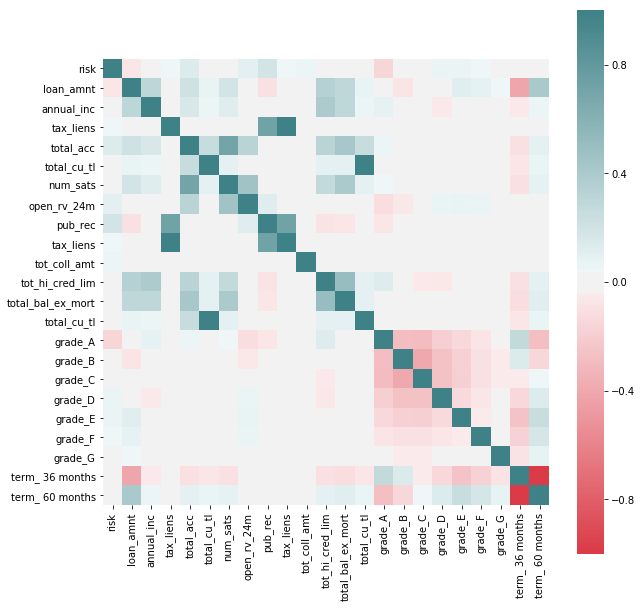

In [4]:
# We create a new feature that will inform of what we'll be considering a default, which we'll use as an outcome that 
# we'll want to avoid.

loan_df['risk'] = int(0)
badLoan = ['Charged Off','Late (31-120 days)',
       'Late (16-30 days)', 'In Grace Period']

loan_df.loc[(loan_df['delinq_amnt'] > 0) | (loan_df['pct_tl_nvr_dlq'] != 100) | 
              (loan_df['total_rec_late_fee'] > 1) | (loan_df['delinq_2yrs'] > 0) | 
              (loan_df['pub_rec_bankruptcies'] > 0) | (loan_df['debt_settlement_flag'] != 'N') |
              loan_df['loan_status'].isin(badLoan),'risk'] = 1

predDefault = loan_df[['risk','grade','loan_amnt','annual_inc','term','int_rate','emp_length','tax_liens','total_acc',
                       'total_cu_tl','hardship_loan_status','num_sats','open_rv_24m','pub_rec','tax_liens',
                       'tot_coll_amt','tot_hi_cred_lim','total_bal_ex_mort','total_cu_tl']]

predDefault = pd.get_dummies(predDefault, columns=['grade', 'term'], drop_first = False)

f, ax = plt.subplots(figsize=(10, 10))

corr = predDefault.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(10, 200, as_cmap=True, center = 'light'),
            square=True, ax=ax)

We see some correlations that may be interesting to explore further between features that indicate potential risk (as by the new feature added to the dataset) and others. We see that the variables by which Lending Club seems to grade loans do indeed have a potential effect on risk (such as term of loan or loan ammount) but we also see others that they don't seem to take in so much consideration as having tax lien or derogatory public records.


It's interesting to point out that better grades, as assigned by Lending Club, don't necessarily correspond with less risk of default, as seen by "charged off" having a negative correlation with Grade G and positive with better levels.

In favor of Lending Club's grading system we see that there seems to be an intrinsic higher risk on higher interest paying loans, at least through this rough preliminary analysis.

##### After all that visualization! Lets Clean the Data!

In [5]:
loans_df = loan_df.copy()

# Drop columns that have been included in imputing the value of the 'risk' new feature
loans_df = loans_df.drop(['delinq_amnt','pct_tl_nvr_dlq','total_rec_late_fee','delinq_2yrs','pub_rec_bankruptcies','loan_status'], axis=1)

#Include all continuous features and outcome 'risk' class
loans_df = loans_df.select_dtypes(include=['float64']).join(loans_df['risk'])

# Include discrete variables that have shown a potential relation with the outcome.
loans_df = loans_df.join(loan_df[['term','grade','emp_length','home_ownership']])

# We remove features that an investor would not have access to at the time of deciding whether to invest or not. We'll also remove
# features that are directly correlated with those used to create the 'risk' outcome or are irrelevant.
loans_df = loans_df.drop(['member_id','hardship_amount', 'hardship_length', 'hardship_dpd','orig_projected_additional_accrued_interest','hardship_payoff_balance_amount', 'hardship_last_payment_amount','settlement_amount', 'settlement_percentage', 'settlement_term','out_prncp','out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp','total_rec_int', 'recoveries', 'collection_recovery_fee','last_pymnt_amnt',], axis=1)

In [6]:
loans_df.columns

Index(['id', 'funded_amnt_inv', 'installment', 'annual_inc', 'url', 'dti',
       'mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_rev_accts', 'num_tl_120dpd_2m', 'percent_bc_gt_75',
       'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_la

In [7]:
def get_columns_to_drop(df):
    """Returns a list of columns from df that is all NaN"""
    columns_to_drop = []
    for col in loans_df.columns:
        unique_rows = loans_df[col].unique()
        if (unique_rows.size == 1 and not isinstance(unique_rows[0], str) and np.isnan(unique_rows[0])):
            columns_to_drop.append(col)
    return columns_to_drop

In [8]:
# drop columns that contains all NaN values
loans_df_columns_to_drop = get_columns_to_drop(loans_df)
loans_df = loans_df.drop(loans_df_columns_to_drop, axis=1)

We now process NaN on a column by column basis to impute the appropriate value in each case

In [9]:
# After studying each column, we see that the best way to remove nan for these cases is to impute 0
for col in loans_df.columns:
    loans_df[col].fillna(0, inplace=True)

After cleaning the dataset of `loans_df`, we were able to reduce from 145 categories to 55 categories.

In [10]:
loans_df.shape

(421095, 39)

### Dimensionality Reduction

In [11]:
# In order to be able to apply PCA we need to hot-one-code all the categorical variables in the dataset
loans_df = pd.get_dummies(loans_df, columns=['term','grade','emp_length','home_ownership'], drop_first=True, prefix=['term_','grade_','emp_','home_'])

In [12]:
loans_df.shape

(421095, 56)

In [13]:
# Split dataset between train and test. We stratify on 'risk' to make sure that we have representation of both categories in the datasets.
loans_train, loans_test = train_test_split(loans_df, test_size=0.2, random_state=8, stratify=loans_df['risk'])

x_train = loans_train.drop(['risk'], axis=1)
y_train = loans_train['risk']

x_test = loans_test.drop(['risk'], axis=1)
y_test = loans_test['risk']

# We scale continuous variables before applying PCA
scale_transformer = StandardScaler(copy=True).fit(x_train)
x_train_scaled = scale_transformer.transform(x_train)
x_test_scaled = scale_transformer.transform(x_test)


# Generate 10 PCA to study the amount of variance that each of them is able to explain
pca_transformer = PCA(10).fit(x_train_scaled)
x_train_10 = pca_transformer.transform(x_train_scaled)
x_test_10 =  pca_transformer.transform(x_test_scaled)

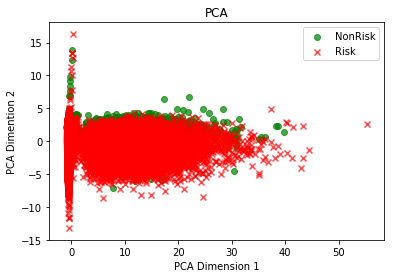

In [14]:
# Plot first two components to explore if they are able to discriminate among classes.
colors = ['g','r']
label_text = ["NonRisk", "Risk"]
markers = ["o","x"]

for risk in [0,1]:
    cur_df = x_train_10[y_train==risk]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[risk], label=label_text[risk], alpha = .7, marker=markers[risk])
    
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.title("PCA")
plt.legend();

In [15]:
# Create a dataframe with the variables and the absolute values of their coeficients
PCA_vectors = pd.DataFrame(abs(pca_transformer.components_), columns=x_train.columns)

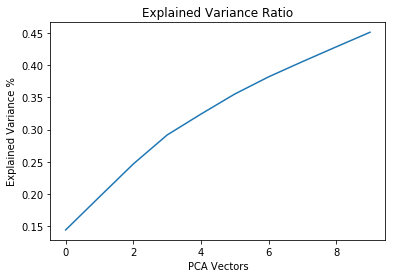

In [16]:
plt.plot(np.cumsum(pca_transformer.explained_variance_ratio_))
plt.xlabel("PCA Vectors")
plt.ylabel("Explained Variance %")
plt.title("Explained Variance Ratio");

Even though the first 10 PCA components only get to explain short of 50% of the variance combined, we find interesting that some of the variables with the higher absolute coefficients in the first vectors are in the group of those that previous analysis indicated that these could be good predictors.

From the results of dimensionality reductions we reduce the set of features to build our further models on to the first 30 with higher coefficients in PCA1

### Random Forest

In [17]:
# We will create a subset of x_train with the 30 variables with the highest coeficients in PCA1
PCA1 = PCA_vectors.iloc[0].sort_values(ascending=False)
subSet = PCA1.iloc[:50].index

x_train_subset = x_train[subSet]
x_test_subset = x_test[subSet]

In [18]:
rf = RandomForestClassifier(n_estimators=25, max_depth=5).fit(x_train_subset,y_train)
rf.score(x_test_subset,y_test)

0.9026110497631176

A Random Forest Classifier was fitted on the training data set and resulted in a 90% accuracy using these features when evaluating the model's performance on the test sit. Repeated runs of each model would result in minor changes to the accuracy scores.

In [19]:
rf_feature_importance = rf.feature_importances_

Text(0,0.5,'Features')

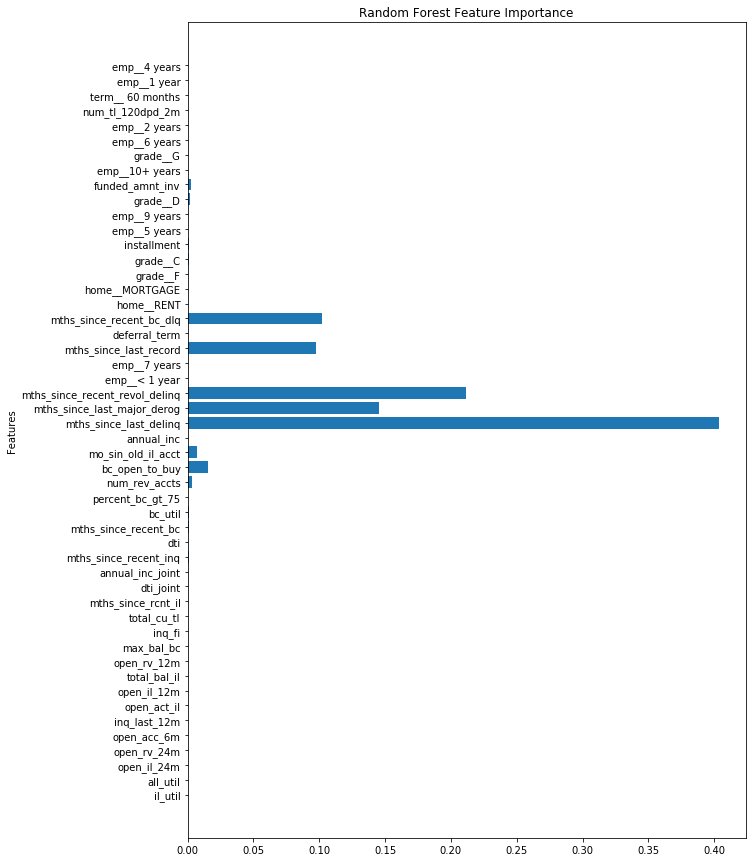

In [20]:
plt.figure(figsize=(10,15))
plt.barh(np.arange(len(x_train_subset.columns)), rf_feature_importance)
plt.title("Random Forest Feature Importance")
plt.yticks(np.arange(len(x_train_subset.columns)), x_train_subset.columns)
plt.ylabel("Features")
# plt.axvline(x=0.03, color = 'k', linestyle = '--')

From the random forest model, it generated a forest of trees of depth of 5. From these multiple generated trees, the importance of each feature is plotted above. 

In [21]:
def get_features_of_rf(feature_names, rf_features, level=0.01):
    f_name = []
    f_val = []
    for name, val in zip(feature_names, rf_features):
        if val > level:
            f_name.append(name)
            f_val.append(val)
    return f_name, f_val
imp_feature_names, imp_feature_vals = get_features_of_rf(x_train.columns, rf_feature_importance)

Text(0,0.5,'Features')

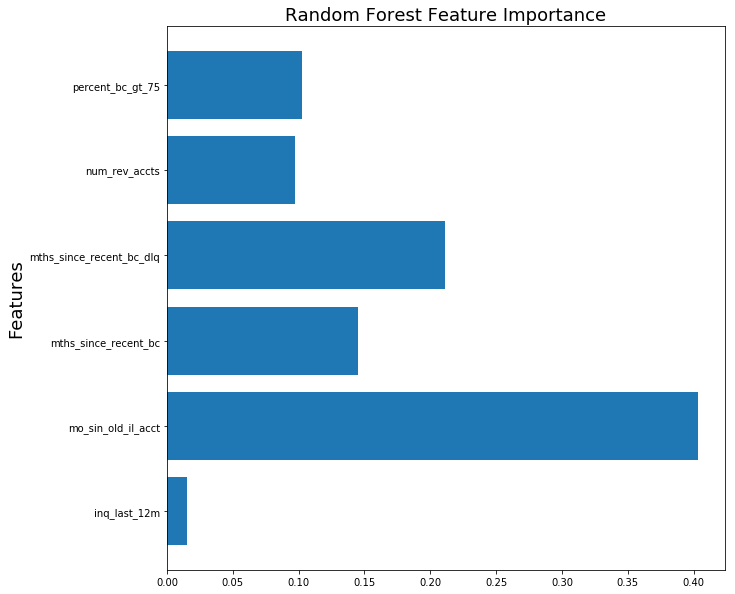

In [22]:
plt.figure(figsize=(10,10))
plt.barh(np.arange(len(imp_feature_names)), imp_feature_vals)
plt.title("Random Forest Feature Importance", fontsize=18)
plt.yticks(np.arange(len(imp_feature_names)), imp_feature_names)
plt.ylabel("Features", fontsize=18)

The following features, (`inq_last_12m`, `bc_open_to_buy`, `mo_sin_old_il_acct`, `mths_since_recent_bc`, `mths_since_recent_bc_dlq`, `num_rev_accts`, `percent_bc_gt_75`) are the features of the random forest model which considers to be the most importance in all of the generated trees. We were very impressed by the results from fitting Random Forest to such a small subset, from which we obtained a score of almost 90% on our test set with a model that trained in only a few seconds.